In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import cv2
import imageio
import datetime

sys.path.append('../deepcell')

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import Input, Model, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Softmax

# from scipy.stats import mode

from skimage.measure import regionprops, regionprops_table

from sklearn import metrics as sk_metrics

In [3]:
from deepcell.mibi_data_help import create_cell_tf_dataset
from deepcell.graph_utils import load_mibi_data, get_marker_dict, load_celltypes, get_max_cells

In [4]:
%%time

# data_path = 'D:/GNN/data/TNBC'
data_path = '../data/TNBC/'

mibi_data_path = os.path.join(data_path, 'TNBCShareData')
mibi_label_path = os.path.join(data_path, 'TNBC_labels/label_images.npy')
mibi_celltype_path = os.path.join(data_path, 'TNBCcellTypes')
TNBCpanelInfo_path = os.path.join(data_path,'TNBCpanelInfo.csv')

# print(mibi_data_path)

POINT_LIST = [2, 5, 8, 9, 21, 22, 24, 26, 34, 37, 38, 41]

mibi_data = load_mibi_data(mibi_data_path, point_list=POINT_LIST)
mibi_labels = np.load(mibi_label_path)
mibi_celltypes = load_celltypes(mibi_celltype_path, point_list=POINT_LIST)

# cell type label codes
"""
  % 0 - background ; 1- Negative ; 2- Endothel ; 3- Mesenchyme ;
  % 4- Tumor ; 5- Immune: Tregs ; 6- Immune: CD4 T ; 7- Immune CD8 T ; 8-
  % Immune CD3 T ; 9- Immune: NK ; 10- Immune: B ; 11- Immune:
  % Neutrophiles ; 12- Immune: Macrophages ; 13- Immune: DC ; 14- Immune:
  % DC/Mono ; 15- Immune: Mono/Neu ; 16: Immune: Other

"""

## created a dictionary of cell types 
celltype_label_dict = {0:'background', 1:'Negative', 2:'Endothel', 3:'Mesenchyme',
                       4:'Tumor', 5:'Tregs', 6:'CD4 T', 7:'CD8 T', 8:'CD3 T',
                       9:'Nk', 10:'B', 11:'Neutrophiles', 12:'Macrophages',
                       13:'DC', 14: 'DC_Mono', 15:'Mono_Neu', 16:'Other'}


# get good channels that were used in original clustering
TNBCpanelInfo = pd.read_csv(TNBCpanelInfo_path)
good_markers = TNBCpanelInfo[TNBCpanelInfo['Used for clustering'] == 1]['Label'].to_list()
marker_dict = get_marker_dict(os.path.join(mibi_data_path,'Point1'))#, index=True)
marker_idxs = list(map(marker_dict.get, good_markers))

# num of features = # of good markers
num_features = len(good_markers)

# create a look up table to go from index to maker name
marker_idx_dict = dict(zip(list(range(len(good_markers))),good_markers))

# Shrink raw data and labelsa to line up with cell type image
tmp_mibi_data = mibi_data[:,30:-30, 30:-30, marker_idxs]
mibi_labels = mibi_labels[:,30:-30, 30:-30, :]
mibi_celltypes = mibi_celltypes[:,30:-30, 30:-30, :]

CPU times: user 43.4 s, sys: 3.85 s, total: 47.2 s
Wall time: 47.2 s


In [5]:
%%time

from deepcell.mibi_data_help import data_split

training_data, validation_data = data_split(tmp_mibi_data,
                                            mibi_labels,
                                            mibi_celltypes,
                                            marker_idx_dict,
                                            train_val_cutoff=.85,
                                            normalize=True)

mibi_data_train, mibi_labels_train, mibi_celltypes_train = training_data
mibi_data_val, mibi_labels_val, mibi_celltypes_val = validation_data

CPU times: user 3min 23s, sys: 2.53 s, total: 3min 25s
Wall time: 3min 25s


In [6]:
%%time 

from deepcell.graph_utils import get_cell_df

cell_df_train = get_cell_df(mibi_data_train, mibi_labels_train, mibi_celltypes_train, good_markers, marker_idx_dict)
cell_df_val = get_cell_df(mibi_data_val, mibi_labels_val, mibi_celltypes_val, good_markers, marker_idx_dict)

CPU times: user 1min 47s, sys: 93.2 ms, total: 1min 47s
Wall time: 1min 47s


In [7]:
from deepcell.mibi_data_help import cells_dataset_from_df

train_dataset, train_df, val_dataset, val_df = cells_dataset_from_df(cell_df_train, cell_df_val)

In [8]:
BATCH_SIZE = 100

train = train_dataset.shuffle(train_df.shape[0]).batch(BATCH_SIZE)
val  = val_dataset.shuffle(val_df.shape[0]).batch(BATCH_SIZE)


#get class names from val data
true_label_data = np.concatenate([y['celltypes'] for x, y in val])
# true_label_data = true_label_data.reshape(true_label_data.shape[0]*true_label_data.shape[1], -1)
true_label = np.argmax(true_label_data, axis=1)
class_names = list(map(celltype_label_dict.__getitem__, set(true_label)))

In [14]:
def dense_model():
    inputs = Input(shape=(23), name='feature_matrix')
    x = inputs
    for i in range(1):
        x = Dense(128, activation='relu')(x)
#         x = BatchNormalization(axis=-1)(x)
#         x = Activation('relu')(x)
    x = Dense(17)(x)
    x = Softmax(axis=-1, name='celltypes')(x)
    return Model(inputs=inputs, outputs=x)

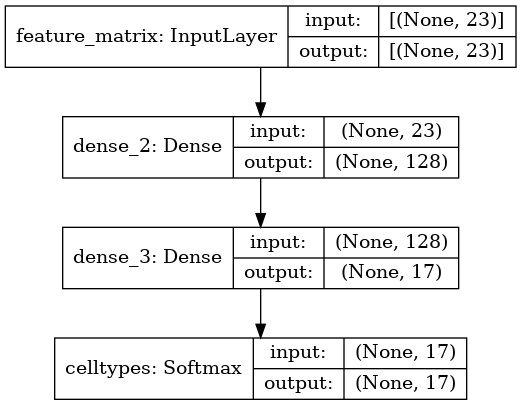

In [15]:
model = dense_model()
plot_model(model, show_shapes=True, to_file='logs/model.png')

In [16]:
from deepcell.losses import weighted_categorical_crossentropy

In [17]:
optimizer = Adam(learning_rate=1e-3)
# losses = {'celltypes': tf.keras.losses.CategoricalCrossentropy()}
losses = {'celltypes': weighted_categorical_crossentropy}
metrics = {'celltypes': ['accuracy', 'Precision', 'Recall']}
model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

In [18]:
model_type = "cells_only-"
log_dir = "logs/"+ model_type + datetime.datetime.now().strftime("%Y_%m_%d-%H%M%S")

# define basic TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(train,
          epochs= 64,
          batch_size= BATCH_SIZE,
          validation_data= val,
          callbacks= [tensorboard_callback])

Epoch 1/64
304/304 [==============================] - 4s 9ms/step - loss: 6.7622 - accuracy: 0.5851 - precision: 0.7638 - recall: 0.1152 - val_loss: 4.0975 - val_accuracy: 0.7655 - val_precision: 0.9312 - val_recall: 0.5627
Epoch 2/64
304/304 [==============================] - 2s 6ms/step - loss: 3.4937 - accuracy: 0.7526 - precision: 0.9389 - recall: 0.5685 - val_loss: 3.5041 - val_accuracy: 0.7705 - val_precision: 0.9056 - val_recall: 0.6563
Epoch 3/64
304/304 [==============================] - 2s 6ms/step - loss: 3.0127 - accuracy: 0.7691 - precision: 0.8850 - recall: 0.6614 - val_loss: 3.3403 - val_accuracy: 0.7752 - val_precision: 0.8794 - val_recall: 0.6863
Epoch 4/64
304/304 [==============================] - 2s 6ms/step - loss: 2.8162 - accuracy: 0.7719 - precision: 0.8642 - recall: 0.6851 - val_loss: 3.2821 - val_accuracy: 0.7765 - val_precision: 0.8704 - val_recall: 0.6975
Epoch 5/64
304/304 [==============================] - 2s 6ms/step - loss: 2.6702 - accuracy: 0.7760 - pr

304/304 [==============================] - 2s 6ms/step - loss: 2.0688 - accuracy: 0.8146 - precision: 0.8523 - recall: 0.7760 - val_loss: 2.8142 - val_accuracy: 0.7957 - val_precision: 0.8420 - val_recall: 0.7603
Epoch 38/64
304/304 [==============================] - 2s 6ms/step - loss: 2.0564 - accuracy: 0.8139 - precision: 0.8529 - recall: 0.7802 - val_loss: 2.8415 - val_accuracy: 0.7945 - val_precision: 0.8354 - val_recall: 0.7624
Epoch 39/64
304/304 [==============================] - 2s 6ms/step - loss: 2.0191 - accuracy: 0.8200 - precision: 0.8557 - recall: 0.7867 - val_loss: 2.7696 - val_accuracy: 0.7895 - val_precision: 0.8351 - val_recall: 0.7568
Epoch 40/64
304/304 [==============================] - 2s 6ms/step - loss: 1.9786 - accuracy: 0.8190 - precision: 0.8571 - recall: 0.7843 - val_loss: 2.8144 - val_accuracy: 0.7978 - val_precision: 0.8393 - val_recall: 0.7663
Epoch 41/64
304/304 [==============================] - 2s 6ms/step - loss: 2.0038 - accuracy: 0.8226 - precision

In [19]:
%load_ext tensorboard
%tensorboard --logdir logs --bind_all

In [20]:
predictions = np.array([])
labels =  np.array([])
for x, y in val:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
    labels = np.concatenate([labels, np.argmax(y['celltypes'].numpy(), axis=-1)])

# Calculate the confusion matrix
#     cm = sk_metrics.confusion_matrix(true_label, test_pred)
cm = sk_metrics.confusion_matrix(labels, predictions, normalize='true')

In [21]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    
    # Compute the labels form the normalized confusion matrix
    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squres are dark; otherwise black
    threshold = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = 'white' if cm[i,j] > threshold else 'black'
        plt.text(j, i, labels[i, j], horizontalalignment='center', color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

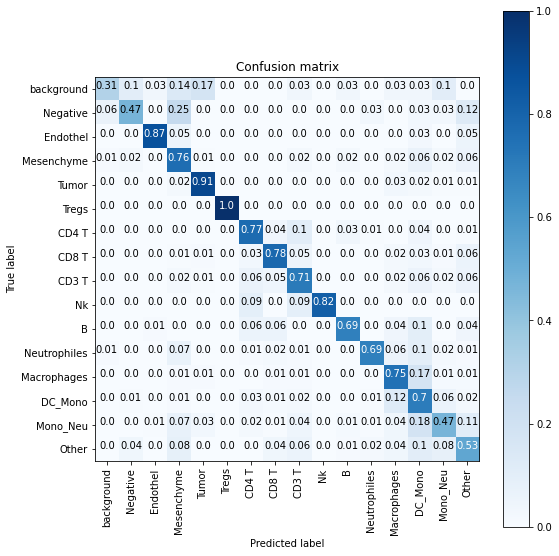

In [22]:
fig = plot_confusion_matrix(cm, class_names)